# Training a FNO on the Shallow Water equations


In [72]:
import time
import sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange


C:\Users\Matteo\AppData\Local\Temp\ipykernel_16904\973606893.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Inital condition: Gauss function

In [251]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss.h5', 'r') as file:
    # List all datasets in the file, skipping meta-entries
    for key in file.keys():
        print(key)
        # Check if each key is a group or dataset
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")


data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x


In [252]:
import h5py
import numpy as np

# Load h_all into array a
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss.h5', 'r') as file:
    h_all = np.array(file['data_0']['h_all'])
    x = np.array(file['data_0']['x'])
    print(f"'h_all' loaded with shape: {a.shape}")


'h_all' loaded with shape: (730, 1, 200)


In [253]:
x = x.squeeze()
h_all = np.real(h_all)

print(x.shape)
print(h_all.shape)

a = h_all[:-1]
a = a[:, np.newaxis, :]
u = h_all[1:]
u = u[:, np.newaxis, :]
print(a.shape)
print(u.shape)

(200,)
(731, 200)
(730, 1, 200)
(730, 1, 200)


In [254]:
mesh = np.linspace(0, 1, u.shape[-1])
print(mesh.shape)

mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)
print(mesh_shape_corrected.shape)

# Concatenate a with mesh_shape_corrected
a_with_mesh = np.concatenate([a, mesh_shape_corrected], axis=1)
print(a_with_mesh.shape)

# Concatenate u with mesh_shape_corrected
u_with_mesh = np.concatenate([u, mesh_shape_corrected], axis=1)
print(u_with_mesh.shape)


(200,)
(730, 1, 200)
(730, 2, 200)
(730, 2, 200)


In [255]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

n = len(a_with_mesh)
print(n)

# Split data into training and test sets
p = 0.8
n_train = int(p * n)
n_test = n - n_train

n_epochs = 100
print(f"n_train = {n_train}, n_test = {n_test}")

cpu
730
n_train = 584, n_test = 146


In [256]:
train_x = torch.tensor(a_with_mesh[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
test_x = torch.tensor(a_with_mesh[n_train:n_train + n_test], dtype=torch.float32)  # Shape (n_test, 3, 256)

train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
test_y = torch.tensor(u[n_train:n_train + n_test], dtype=torch.float32)  # Shape (n_test, ...)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([584, 2, 200]) torch.Size([584, 1, 200]) torch.Size([146, 2, 200]) torch.Size([146, 1, 200])


In [257]:
test_mesh = torch.tensor(np.repeat(mesh[np.newaxis, np.newaxis, :], test_y.shape[0], axis=0),dtype=torch.float32)
print(test_mesh.shape)

torch.Size([146, 1, 200])


In [258]:
model = TFNO(
    n_modes=(16,), 
    in_channels=2, 
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=2, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 309058 parameters.


In [259]:
def dataloader_torch(dataset_x,dataset_y,batch_size,):
    dataset = torch.utils.data.TensorDataset(dataset_x, dataset_y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

In [260]:
learn_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)
dataloader_train = dataloader_torch(train_x, train_y, batch_size=32)

In [261]:
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)
for epoch in tqdm(range(n_epochs), unit='epoch'):
    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = torch.mean((y_pred - y) ** 2)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        with torch.no_grad():
            test_x, test_y = test_x.to(device), test_y.to(device)
            validation_loss = torch.mean((model(test_x) - test_y) ** 2).item()
            loss_val.append(validation_loss)
            # save model weighs if validation loss is minimal
            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                torch.save(model.state_dict(), f"best_model_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pth")
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(validation_loss)
    else:
        scheduler.step()


  0%|          | 0/100 [00:00<?, ?epoch/s]

torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])
torch.Size([32, 1, 200])
torch.Size([32, 2, 200])
torch.Size([32, 2, 200])


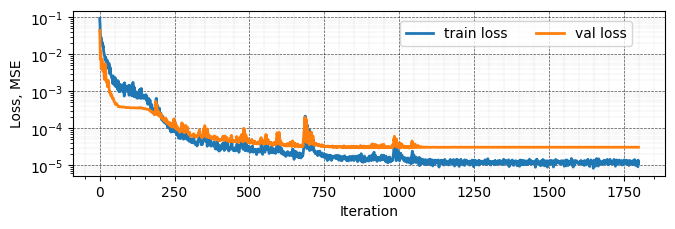

In [262]:
inch = 2.54
fig_size = 17

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)
ax.semilogy(loss_train, label="train loss",linewidth = 2)
ax.semilogy(loss_val, label="val loss",linewidth = 2)

ax.set_xlabel("Iteration")

ax.set_ylabel("Loss, MSE")
# ax.spines['bottom'].set_position('zero')
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='k', alpha=0.7)

# Minor gridlines
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth='0.3', color='k', alpha=0.3)

fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels,ncol = 5, bbox_to_anchor=(0.95,0.95))


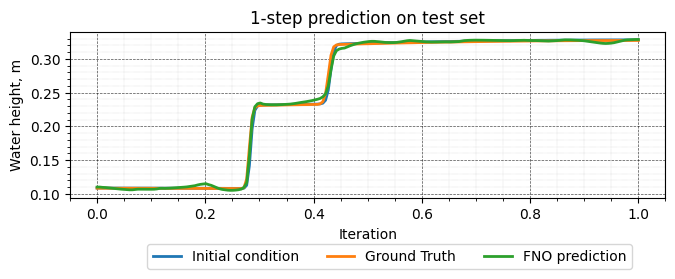

In [268]:
inch = 2.54
from matplotlib.ticker import FuncFormatter
fig_size = 17
def custom_formatter(x, pos):
    if abs(x) >= 1000:
        return f'{x:.2e}'  # Use scientific notation
    else:
        return f'{x:.3f}'  # Use plain format with 3 digits
    
fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)
ax.plot(mesh,test_x[1, 0].cpu(), label="Initial condition",linewidth = 2)
ax.plot(mesh,test_y[1, 0].cpu(), label="Ground Truth",linewidth = 2)
ax.plot(mesh,model(test_x).cpu().detach().numpy()[1,0], label="FNO prediction",linewidth = 2)

ax.set_xlabel("Iteration")
ax.set_ylabel("Water height, m")
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='k', alpha=0.7)

# Minor gridlines
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth='0.3', color='k', alpha=0.3)

fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
# ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax.set_title('1-step prediction on test set')
lgd = fig.legend(handles, labels,ncol = 5, bbox_to_anchor=(0.95,0.05))


In [265]:
ax.plot(mesh,test_x[1, 0].cpu(), label="Initial condition",linewidth = 2)


IndexError: index 1 is out of bounds for dimension 1 with size 1

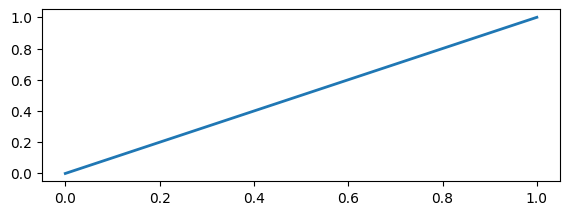

In [264]:
inch = 2.54
from matplotlib.ticker import FuncFormatter
fig_size = 17
def custom_formatter(x, pos):
    if abs(x) >= 1000:
        return f'{x:.2e}'  # Use scientific notation
    else:
        return f'{x:.3f}'  # Use plain format with 3 digits
    
fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)
ax.plot(mesh,test_x[1, 1].cpu(), label="Initial condition",linewidth = 2)
ax.plot(mesh,test_y[1, 1].cpu(), label="Ground Truth",linewidth = 2)
ax.plot(mesh,model(test_x).cpu().detach().numpy()[1,1], label="FNO prediction",linewidth = 2)

ax.set_xlabel("Iteration")
ax.set_ylabel("Momentum")
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='k', alpha=0.7)

# Minor gridlines
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth='0.3', color='k', alpha=0.3)

fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
# ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax.set_title('1-step prediction on test set')
lgd = fig.legend(handles, labels,ncol = 5, bbox_to_anchor=(0.95,0.05))


In [101]:
# create forloop to iterate over the time steps feeding model predictions back into the model 
preds = [torch.tensor(data['sim_800'][0],dtype=torch.float32)]
steps = 5
for i in range(steps):
    if i == 0:
        preds.append(model(torch.unsqueeze(torch.cat((torch.tensor(data['sim_800'][0],dtype=torch.float32),test_mesh[0])),0)))
    else:
        preds.append(model(torch.cat((preds[-1], torch.unsqueeze(test_mesh[0],0)), dim=1)))


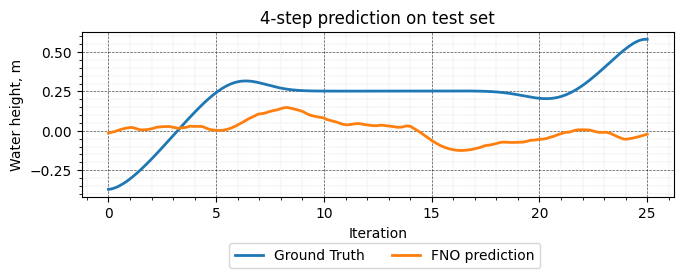

In [102]:
inch = 2.54
from matplotlib.ticker import FuncFormatter
fig_size = 17
def custom_formatter(x, pos):
    if abs(x) >= 1000:
        return f'{x:.2e}'  # Use scientific notation
    else:
        return f'{x:.3f}'  # Use plain format with 3 digits
    
fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)
ax.plot(mesh,data['sim_800'][4][1], label="Ground Truth",linewidth = 2)
ax.plot(mesh,preds[4][0][1].detach().numpy(), label="FNO prediction",linewidth = 2)

ax.set_xlabel("Iteration")
ax.set_ylabel("Water height, m")
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='k', alpha=0.7)

# Minor gridlines
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth='0.3', color='k', alpha=0.3)

fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
# ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax.set_title('4-step prediction on test set')
lgd = fig.legend(handles, labels,ncol = 2, bbox_to_anchor=(0.8,0.05))
